In [11]:
import policy
import config

import os
import torch
import numpy as np
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [12]:
cwd = os.getcwd()
parameter_file = 'nn_model_1_reward_type_4.pt'
cwd = os.path.join(cwd,parameter_file)

device = torch.device('cpu')
model = policy.policy(observation_space_size=config.observation_space_size,
                           action_space_size=config.action_space_size,
                           hidden_size=config.HIDDEN_SIZE).to(device)
model.load_state_dict(torch.load(cwd, map_location=device))

<All keys matched successfully>

In [13]:
import trading_spy_with_many_discrete_actions_reward_type_4

In [14]:
local_env = trading_spy_with_many_discrete_actions_reward_type_4.trading_spy(config.max_simulation_length,
                                                                            config.min_history_length,
                                                                            config.max_position,
                                                                            config.init_cash_value)

In [15]:
total_portfolio_value = []
stock_price = []
stock_percentage = []
recorded_action = [0]#i always start with all cash



In [16]:
observation_dict = local_env.reset()

total_portfolio_value.append(observation_dict['current_portfolio_value'])
stock_price.append(observation_dict['raw_price'][-1])
stock_percentage.append(observation_dict['current_stock_ratio'])

In [17]:
for time_index in range(0,1000):
    
    observation_dict['price_history'].append(observation_dict['current_stock_ratio'])
    nn_input = np.asarray(observation_dict['price_history'])
    action_logits = model(torch.tensor(nn_input).float().unsqueeze(dim=0).to(device))
    action = Categorical(logits=action_logits).sample()
    
    observation_dict, reward, execute_action = local_env.step(action=action.cpu().item())
    
    total_portfolio_value.append(observation_dict['current_portfolio_value'])
    stock_price.append(observation_dict['raw_price'][-1])
    stock_percentage.append(observation_dict['current_stock_ratio'])
    recorded_action.append(observation_dict['action'])

In [18]:
print(len(total_portfolio_value))
print(len(stock_price))
print(len(stock_percentage))
print(len(recorded_action))

1001
1001
1001
1001


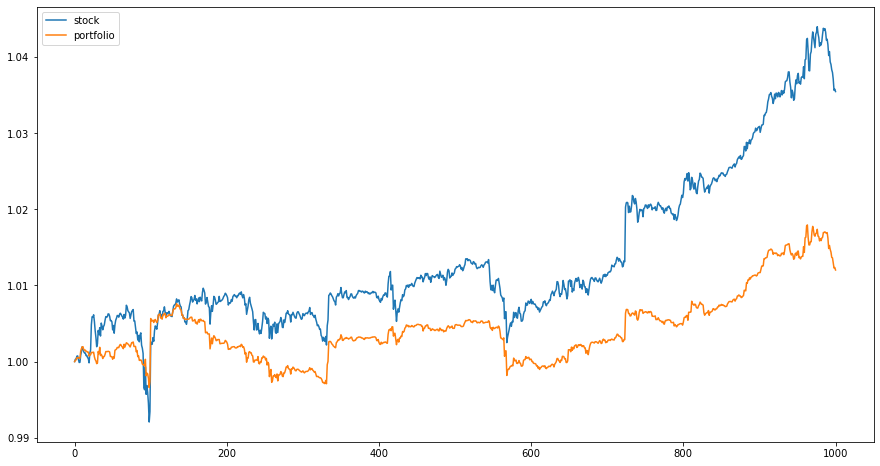

In [19]:
plt.rcParams["figure.figsize"] = (15,8)


plt.plot(np.asarray(stock_price)/stock_price[0],label = 'stock')
plt.plot(np.asarray(total_portfolio_value)/total_portfolio_value[0],label = 'portfolio')
plt.legend()
plt.show()

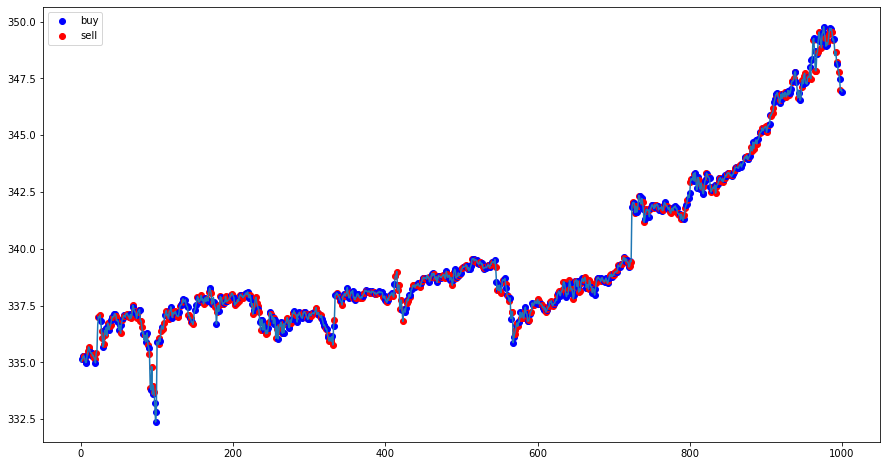

In [20]:
already_plotted_sell_legend = False
already_plotted_buy_legend = False

plt.plot(stock_price)
for time_index in range(1,len(recorded_action)):

    
    if recorded_action[time_index]>recorded_action[time_index-1]:
        #buy
        if already_plotted_buy_legend == False:
            plt.scatter(time_index,stock_price[time_index],color = 'b',label = 'buy')
            already_plotted_buy_legend = True
        else:
            plt.scatter(time_index,stock_price[time_index],color = 'b')
        
    if recorded_action[time_index]<recorded_action[time_index-1]:
        #sell
        if already_plotted_sell_legend == False:
            plt.scatter(time_index,stock_price[time_index],color = 'r',label = 'sell')
            already_plotted_sell_legend = True
        else:
            plt.scatter(time_index,stock_price[time_index],color = 'r')
    
plt.legend()
plt.show()